# Post-processing example Delft3D4
To get Delft3D4 to write netCDF output instead of .dat files, add these lines to your model settings file (.mdf):
- `FlNcdf= #maphis#`
- `ncFormat=4`

If you prefer to interact with a Python script instead, you can convert this notebook to *.py with `jupyter nbconvert --to script postprocessing_example_delft3d4.ipynb`.


In [1]:
# imports
import matplotlib.pyplot as plt
plt.close('all')
import dfm_tools as dfmt
import xarray as xr


In [2]:
# set paths and parameters per model
# the necessary data is automatically downloaded from opendap if needed (except for kivu)
model = 'westernscheldt' # 'kivu', 'curvedbend', 'westernscheldt'

if model == 'curvedbend':
    file_map = dfmt.data.d3d_curvedbend_trim(return_filepath=True)
    file_his = dfmt.data.d3d_curvedbend_trih(return_filepath=True)
    timestep = 4
    layno = -1
    res = 100
    scale = 25
    figsize = (6,5)
    add_coastlines = False
    stations_requested = ['Outer-south', 'inner-south', 'inner-middle']
elif model == 'westernscheldt':
    file_map = dfmt.data.d3d_westernscheldt_trim(return_filepath=True)
    file_his = None
    timestep = 10
    layno = 0
    res = 1/70
    scale = 30
    figsize = (10,4)
    add_coastlines = True
    stations_requested = []
elif model == 'kivu':
    file_map = r'p:\archivedprojects\1220688-lake-kivu\3_modelling\1_FLOW\7_heatfluxinhis\062_netcdf\trim-thiery_002_coarse.nc'
    file_his = r'p:\archivedprojects\1220688-lake-kivu\3_modelling\1_FLOW\7_heatfluxinhis\063_netcdf\trih-thiery_002_coarse.nc'
    timestep = 10
    layno = -2
    res = 1/70
    scale = 3
    figsize = (6,7)
    add_coastlines = True
    stations_requested = ['ADCP1_final','ADCP2_final','KP1_016']
else:
    raise Exception(f'undefined model: {model}')


In [3]:
# open Delft3D4 netcdf his dataset
if file_his:
    data_xr = xr.open_mfdataset(file_his, preprocess=dfmt.preprocess_hisnc)
    vars_pd = dfmt.get_ncvarproperties(data_xr)


In [4]:
# plot waterlevel from hisfile
if file_his:
    da_zws = data_xr.ZWL.sel(NOSTAT=stations_requested)
    fig, ax = plt.subplots(figsize=(10,6))
    da_zws.plot.line('-', ax=ax, x='time')


In [5]:
# plot u velocity from hisfile
if file_his:
    da_dps = data_xr.ZCURU.sel(NOSTAT=stations_requested).isel(KMAXOUT_RESTR=0)
    fig, ax = plt.subplots(figsize=(10,6))
    da_dps.plot.line('-', ax=ax, x='time')


In [6]:
# open Delft3D4 netcdf map dataset
uds = dfmt.open_dataset_delft3d4(file_map)
# select timestep
uds_sel = uds.isel(time=timestep,KMAXOUT_RESTR=layno)
# rasterize (for vector plots)
uds_raster = dfmt.rasterize_ugrid(uds_sel,resolution=res)


>> rasterizing ugrid Dataset with 12 face variables to shape=(20,70): 0.45 sec


>> reading coastlines: 1.31 sec


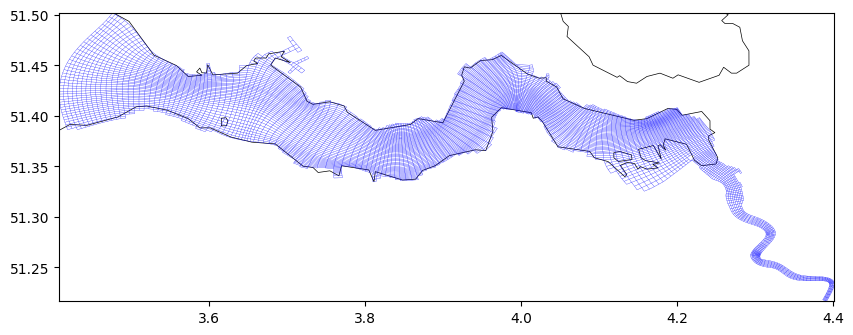

In [7]:
# plot grid
fig,ax = plt.subplots(figsize=figsize)
uds.grid.plot(ax=ax, color='b',linewidth=0.2)
if add_coastlines:
    dfmt.plot_coastlines(ax=ax, res='h')


>> reading coastlines: 0.68 sec


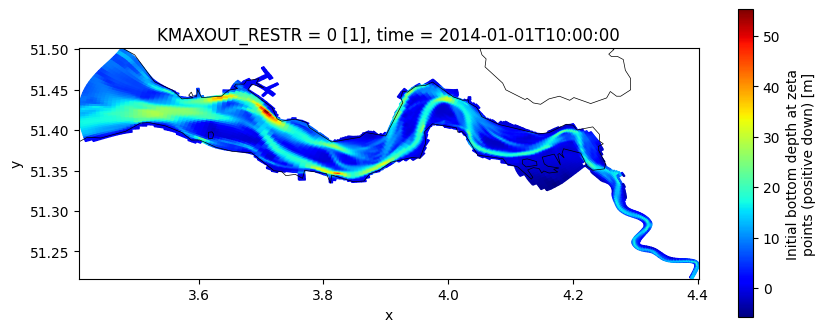

In [8]:
# plot bottom depth
fig,ax = plt.subplots(figsize=figsize)
uds_sel.DPS0.ugrid.plot(ax=ax, center=False, cmap='jet')
if add_coastlines:
    dfmt.plot_coastlines(ax=ax, res='h')


>> reading coastlines: 0.73 sec


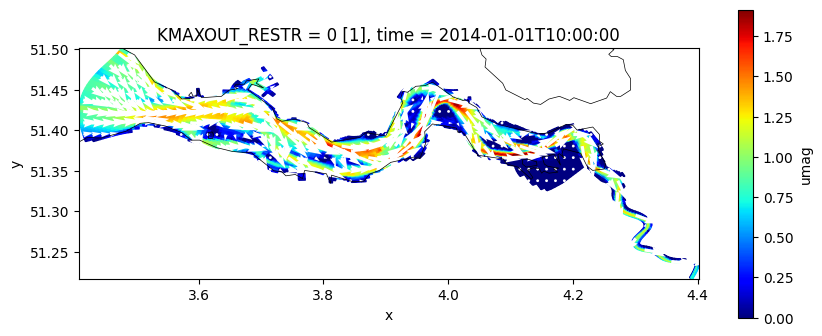

In [9]:
# plot current velocities
fig,ax = plt.subplots(figsize=figsize)
uds_sel.umag.ugrid.plot(ax=ax, center=False, cmap='jet')
pc = ax.quiver(uds_raster.x, uds_raster.y, uds_raster.ux, uds_raster.uy,
          scale=scale,color='w',width=0.005, cmap='jet')
if add_coastlines:
    dfmt.plot_coastlines(ax=ax, res='h')


>> reading coastlines: 0.70 sec


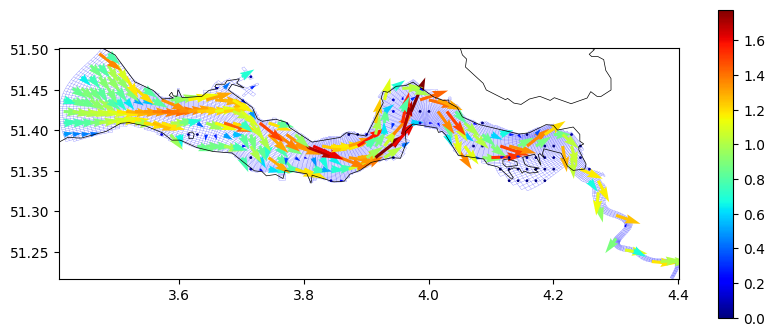

In [10]:
# plot current velocities
fig,ax = plt.subplots(figsize=figsize)
uds.grid.plot(ax=ax, color='b',linewidth=0.2, zorder=0, alpha=0.6)
pc = ax.quiver(uds_raster.x, uds_raster.y, uds_raster.ux, uds_raster.uy, uds_raster.umag,
          scale=scale,color='w',width=0.005, cmap='jet')
fig.colorbar(pc,ax=ax)
if add_coastlines:
    dfmt.plot_coastlines(ax=ax, res='h')